In [28]:
"""!pip install pystac
!pip install pystac_client
!pip install planetary_computer
!pip install nb_black
!pip install odc-stac
!pip install geopandas
!pip install rioxarray
!pip install loguru
!pip install opencv-python
!pip install geopy
!pip install path
!pip install tqdm"""

'!pip install pystac\n!pip install pystac_client\n!pip install planetary_computer\n!pip install nb_black\n!pip install odc-stac\n!pip install geopandas\n!pip install rioxarray\n!pip install loguru\n!pip install opencv-python\n!pip install geopy\n!pip install path\n!pip install tqdm'

In [29]:
%load_ext lab_black
%load_ext autoreload
%autoreload 2

The lab_black extension is already loaded. To reload it, use:
  %reload_ext lab_black
The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [30]:
import cv2
from datetime import timedelta
import matplotlib.pyplot as plt
import numpy as np
import odc.stac
import pandas as pd
from pathlib import Path
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler
from tqdm import tqdm

%matplotlib inline

In [31]:
DATA_DIR = Path.cwd().parent.resolve() / r"Documents\ticktickbloom"
assert DATA_DIR.exists()

# **metadata.csv**

In [32]:
metadata = pd.read_csv(DATA_DIR / "metadata.csv")
metadata.head()

,uid,latitude,longitude,date,split
0,aabm,39.080319,-86.430867,2018-05-14,train
1,aabn,36.559700,-121.510000,2016-08-31,test
2,aacd,35.875083,-78.878434,2020-11-19,train
3,aaee,35.487000,-79.062133,2016-08-24,train
4,aaff,38.049471,-99.827001,2019-07-23,train


In [33]:
metadata.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23570 entries, 0 to 23569
Data columns (total 5 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   uid        23570 non-null  object 
 1   latitude   23570 non-null  float64
 2   longitude  23570 non-null  float64
 3   date       23570 non-null  object 
 4   split      23570 non-null  object 
dtypes: float64(2), object(3)
memory usage: 920.8+ KB


# **train_labels.csv**

In [34]:
train_labels = pd.read_csv(DATA_DIR / "train_labels.csv")
train_labels.head()

,uid,region,severity,density
0,aabm,midwest,1,585.0
1,aacd,south,1,290.0
2,aaee,south,1,1614.0
3,aaff,midwest,3,111825.0
4,aafl,midwest,4,2017313.0


In [35]:
train_labels.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17060 entries, 0 to 17059
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   uid       17060 non-null  object 
 1   region    17060 non-null  object 
 2   severity  17060 non-null  int64  
 3   density   17060 non-null  float64
dtypes: float64(1), int64(1), object(2)
memory usage: 533.2+ KB


<AxesSubplot: >

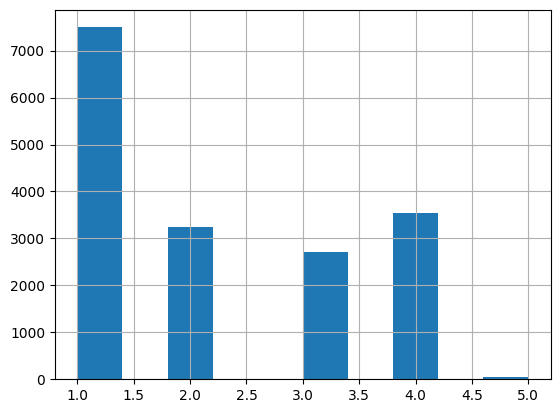

In [36]:
train_labels["severity"].hist()

In [37]:
train_labels["density"].describe()

count    1.706000e+04
mean     1.074537e+06
std      6.836693e+06
min      0.000000e+00
25%      4.066000e+03
50%      3.270975e+04
75%      4.849192e+05
max      8.046675e+08
Name: density, dtype: float64

C:\Users\Administrateur\AppData\Local\Temp\ipykernel_11244\3295648470.py:3: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(


<AxesSubplot: xlabel='density', ylabel='Density'>

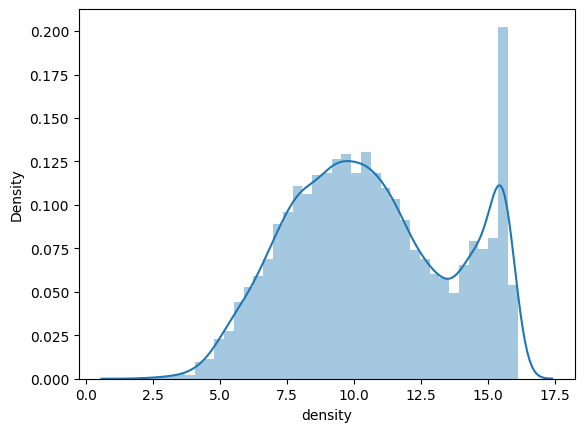

In [38]:
import seaborn as sns

sns.distplot(
    np.log(
        train_labels[(train_labels["density"] > 0) & (train_labels["density"] < 1e7)][
            "density"
        ]
    )
)

C:\Users\Administrateur\AppData\Local\Temp\ipykernel_11244\730536015.py:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  sns.heatmap(train_labels.corr(), annot=True, cmap="coolwarm", center=0)


<AxesSubplot: >

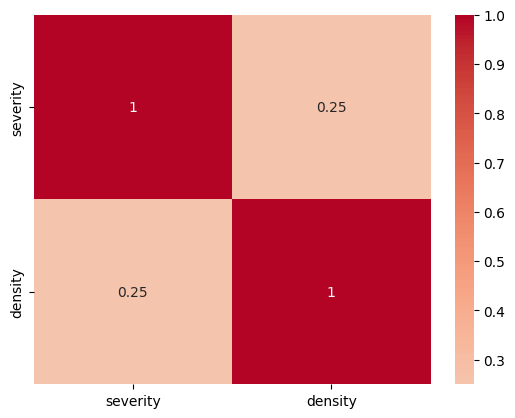

In [39]:
sns.heatmap(train_labels.corr(), annot=True, cmap="coolwarm", center=0)

DATA_merge

In [40]:
data = train_labels.merge(
    metadata, how="left", left_on="uid", right_on="uid", validate="1:1"
)
data

,uid,region,severity,density,latitude,longitude,date,split
0,aabm,midwest,1,585.0,39.080319,-86.430867,2018-05-14,train
1,aacd,south,1,290.0,35.875083,-78.878434,2020-11-19,train
2,aaee,south,1,1614.0,35.487000,-79.062133,2016-08-24,train
3,aaff,midwest,3,111825.0,38.049471,-99.827001,2019-07-23,train
4,aafl,midwest,4,2017313.0,39.474744,-86.898353,2021-08-23,train
...,...,...,...,...,...,...,...,...
17055,zzsv,south,3,113125.0,38.707825,-75.080867,2018-06-27,train
17056,zzuq,south,3,175726.0,35.794000,-79.015368,2015-08-06,train
17057,zzwo,midwest,2,48510.0,39.792190,-99.971050,2017-06-19,train
17058,zzwq,south,1,1271.0,35.794000,-79.012551,2015-03-24,train


C:\Users\Administrateur\AppData\Local\Temp\ipykernel_11244\2638242000.py:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  sns.heatmap(data.corr(), annot=True, cmap="coolwarm", center=0)


<AxesSubplot: >

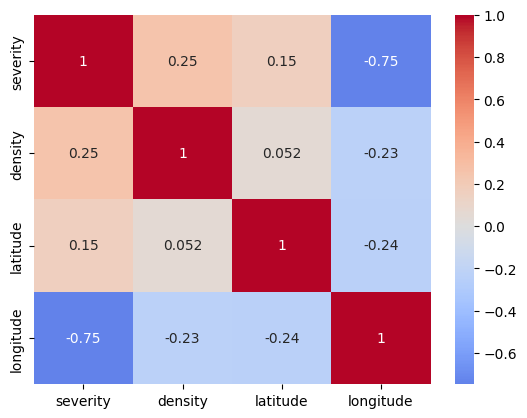

In [41]:
sns.heatmap(data.corr(), annot=True, cmap="coolwarm", center=0)

# **Process feature data**

In [42]:
import rioxarray
from IPython.display import Image
from PIL import Image as PILImage

In [43]:
# Establish a connection to the STAC API
import planetary_computer as pc
from pystac_client import Client

catalog = Client.open(
    "https://planetarycomputer.microsoft.com/api/stac/v1", modifier=pc.sign_inplace
)

In [44]:
import geopy.distance as distance


# get our bounding box to search latitude and longitude coordinates
def get_bounding_box(latitude, longitude, meter_buffer=50000):
    """
    Given a latitude, longitude, and buffer in meters, returns a bounding
    box around the point with the buffer on the left, right, top, and bottom.

    Returns a list of [minx, miny, maxx, maxy]
    """
    distance_search = distance.distance(meters=meter_buffer)

    # calculate the lat/long bounds based on ground distance
    # bearings are cardinal directions to move (south, west, north, and east)
    min_lat = distance_search.destination((latitude, longitude), bearing=180)[0]
    min_long = distance_search.destination((latitude, longitude), bearing=270)[1]
    max_lat = distance_search.destination((latitude, longitude), bearing=0)[0]
    max_long = distance_search.destination((latitude, longitude), bearing=90)[1]

    return [min_long, min_lat, max_long, max_lat]


# get our date range to search, and format correctly for query
def get_date_range(date, time_buffer_days=15):
    """Get a date range to search for in the planetary computer based
    on a sample's date. The time range will include the sample date
    and time_buffer_days days prior

    Returns a string"""
    datetime_format = "%Y-%m-%dT"
    range_start = pd.to_datetime(date) - timedelta(days=time_buffer_days)
    date_range = f"{range_start.strftime(datetime_format)}/{pd.to_datetime(date).strftime(datetime_format)}"

    return date_range


def crop_sentinel_image(item, bounding_box):
    """
    Given a STAC item from Sentinel-2 and a bounding box tuple in the format
    (minx, miny, maxx, maxy), return a cropped portion of the item's visual
    imagery in the bounding box.

    Returns the image as a numpy array with dimensions (color band, height, width)
    """
    (minx, miny, maxx, maxy) = bounding_box

    image = rioxarray.open_rasterio(pc.sign(item.assets["visual"].href)).rio.clip_box(
        minx=minx,
        miny=miny,
        maxx=maxx,
        maxy=maxy,
        crs="EPSG:4326",
    )

    return image.to_numpy()


def crop_landsat_image(item, bounding_box):
    """
    Given a STAC item from Landsat and a bounding box tuple in the format
    (minx, miny, maxx, maxy), return a cropped portion of the item's visual
    imagery in the bounding box.

    Returns the image as a numpy array with dimensions (color band, height, width)
    """
    (minx, miny, maxx, maxy) = bounding_box

    image = odc.stac.stac_load(
        [pc.sign(item)], bands=["red", "green", "blue"], bbox=[minx, miny, maxx, maxy]
    ).isel(time=0)
    image_array = image[["red", "green", "blue"]].to_array().to_numpy()

    # normalize to 0 - 255 values
    image_array = cv2.normalize(image_array, None, 0, 255, cv2.NORM_MINMAX)

    return image_array


# Refactor our process from above into functions
# Refactor our process from above into functions
def select_best_item(items, date, latitude, longitude):
    """
    Select the best satellite item given a sample's date, latitude, and longitude.
    If any Sentinel-2 imagery is available, returns the closest sentinel-2 image by
    time. Otherwise, returns the closest Landsat imagery.

    Returns a tuple of (STAC item, item platform name, item date)
    """
    # get item details
    item_details = pd.DataFrame(
        [
            {
                "datetime": item.datetime.strftime("%Y-%m-%d"),
                "platform": item.properties["platform"],
                "min_long": item.bbox[0],
                "max_long": item.bbox[2],
                "min_lat": item.bbox[1],
                "max_lat": item.bbox[3],
                "item_obj": item,
            }
            for item in items
        ]
    )

    # filter to items that contain the point location, or return None if none contain the point
    item_details["contains_sample_point"] = (
        (item_details.min_lat < latitude)
        & (item_details.max_lat > latitude)
        & (item_details.min_long < longitude)
        & (item_details.max_long > longitude)
    )
    item_details = item_details[item_details["contains_sample_point"] == True]
    if len(item_details) == 0:
        return (np.nan, np.nan, np.nan)

    # add time difference between each item and the sample
    item_details["time_diff"] = pd.to_datetime(date) - pd.to_datetime(
        item_details["datetime"]
    )

    # if we have sentinel-2, filter to sentinel-2 images only
    item_details["sentinel"] = item_details.platform.str.lower().str.contains(
        "sentinel"
    )
    if item_details["sentinel"].any():
        item_details = item_details[item_details["sentinel"] == True]

        # return the closest imagery by time
        listitems = item_details.sort_values(by="time_diff", ascending=True)

        for i in range(len(listitems)):
            cloud_coverage = listitems.iloc[i, 6].properties["eo:cloud_cover"]
            shadow_pixels = listitems.iloc[i, 6].properties[
                "s2:cloud_shadow_percentage"
            ]
            no_pixel_data = listitems.iloc[i, 6].properties[
                "s2:nodata_pixel_percentage"
            ]
            degraded_msi_data_percentage = listitems.iloc[i, 6].properties[
                "s2:degraded_msi_data_percentage"
            ]
            if (
                no_pixel_data < 10
                and cloud_coverage < 10
                and shadow_pixels < 10
                and degraded_msi_data_percentage < 10
            ):
                best_item = listitems.iloc[i]
    # if we have sentinel-2, filter to sentinel-2 images only
    else:
        item_details = item_details[item_details["landsat"] == True]
        listitems = item_details.sort_values(by="time_diff", ascending=True)
        for i in range(len(listitems)):
            # return the closest imagery by time
            cloud_coverage_land = listitems.iloc[i, 6].properties[
                "landsat:cloud_cover_land"
            ]
            cloud_coverage = listitems.iloc[i, 6].properties["eo:cloud_cover"]
            if cloud_coverage < 10 and cloud_coverage_land < 10:
                best_item = listitems.iloc[i]
    return (
        best_item["item_obj"],
        best_item["platform"],
        best_item["datetime"],
    )


def image_to_features(image_array):
    """
    Convert an image array of the form (color band, height, width) to a
    1-dimensional list of features. Returns a list where the first three
    values are the averages of each color band, and the second three
    values are the medians of each color band.
    """
    averages = image_array.mean(axis=(1, 2)).tolist()
    medians = np.median(image_array, axis=(1, 2)).tolist()

    return averages + medians

In [45]:
BENCHMARK_DATA_DIR = DATA_DIR.parents[0] / "ticktickbloom/benchmark"

# save image arrays in case we want to generate more features
IMAGE_ARRAY_DIR = BENCHMARK_DATA_DIR / "images3"
IMAGE_ARRAY_DIR.mkdir(exist_ok=True, parents=True)

In [69]:
# take a random subset of the training data for the benchmark
train_subset = metadata[metadata["split"] == "train"].sample(n=17060, random_state=2)
test_subset = metadata[metadata["split"] == "test"]
# combine train subset with all test data
metadata_subset = pd.concat([train_subset, metadata[metadata["split"] == "test"]])
metadata_subset.split.value_counts(dropna=False)

train    17060
test      6510
Name: split, dtype: int64

In [70]:
test_subset

,uid,latitude,longitude,date,split
1,aabn,36.559700,-121.510000,2016-08-31,test
12,aair,33.042600,-117.076000,2014-11-01,test
14,aajw,40.703968,-80.293050,2015-08-26,test
15,aalr,38.972500,-94.672930,2019-08-26,test
16,aalw,34.279000,-118.905000,2018-01-08,test
...,...,...,...,...,...
23556,zzpn,40.136410,-80.473740,2019-07-08,test
23560,zzrv,36.875400,-121.561000,2019-09-17,test
23563,zzsx,34.210000,-78.929389,2019-07-16,test
23565,zzvv,36.708500,-121.749000,2014-12-02,test


In [47]:
import rioxarray
import imageio
from IPython.display import Image
from PIL import Image as PILImage
from joblib import Parallel, delayed
import multiprocessing
import pandas as pd




def extract_images(row):
    pass
    # check if we've already saved the selected image array
    image_array_pth = IMAGE_ARRAY_DIR / f"{row.uid}.npy"

    if image_array_pth.exists():
        with open(image_array_pth, "rb") as f:
            image_array = np.load(f)

    # search and load the image array if not
    else:
        try:
            ## QUERY STAC API
            # get query ranges for location and date
            search_bbox = get_bounding_box(
                row.latitude, row.longitude, meter_buffer=50000
            )
            date_range = get_date_range(row.date, time_buffer_days=15)

            # search the planetary computer
            search = catalog.search(
                collections=["sentinel-2-l2a", "landsat-c2-l2"],
                bbox=search_bbox,
                datetime=date_range,
            )
            items = [item for item in search.get_all_items()]

            ## GET BEST IMAGE
            if len(items) == 0:
                pass
            else:
                best_item, item_platform, item_date = select_best_item(
                    items, row.date, row.latitude, row.longitude
                )
                # add to dictionary tracking best items
                selected_items[row.uid] = {
                    "item_object": best_item,
                    "item_platform": item_platform,
                    "item_date": item_date,
                }

            ## CONVERT TO FEATURES
            # get small bbox just for features
            feature_bbox = get_bounding_box(
                row.latitude, row.longitude, meter_buffer=3000
            )

            # crop the image
            if "sentinel" in item_platform.lower():
                image_array = crop_sentinel_image(best_item, feature_bbox)
            else:
                image_array = crop_landsat_image(best_item, feature_bbox)

            # save image array so we don't have to rerun
            image = np.transpose(image_array, axes=[1, 2, 0]).astype(np.uint8)
            imageio.imwrite(IMAGE_ARRAY_DIR / f"{row.uid}.png", image)
   

        # keep track of any that ran into errors without interrupting the process
        except:
            errored_ids.append(row.uid)
    return "ok"

In [68]:
# save outputs in dictionaries
selected_items = {}
features_dict = {}
errored_ids = []


# Perform the parallel computation using joblib
results = Parallel(n_jobs=-1)(
    delayed(extract_images_dataframe)(row)
    for row in tqdm(data.itertuples(), total=len(data))
)

In [67]:
import os

paths = sorted(list(IMAGE_ARRAY_DIR.glob("*.png")))
path_list = os.path.split(paths[0])
id = path_list[1][:4]
id

'aabm'

In [57]:
class Dataset(torch.utils.data.Dataset):
        
        def __init__(self, IMAGE_ARRAY_DIR):
                self.image_paths = sorted(list(IMAGE_ARRAY_DIR.glob("*.png")))
        
        def load_image(self, index: int):
                image_path = self.image_paths[index]
                path_list = os.path.split(image_path)
                id = path_list[1][:4]
                selected_items[row.uid]
                return Image.open(image_path)       


uid          aacd
region      south
severity        1
density     290.0
Name: 1, dtype: object